In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load model

In [32]:
from joblib import dump, load
#svm = load('models/one_class_svm_aphids_20211018.joblib')
svm = load('models/OCSVM_model.joblib')


# Load training dataset

In [33]:
wave_lengths = pd.read_csv("data_training/wave_lengths.csv",index_col=0,header=None)[1]

In [34]:
X_explore = pd.read_csv("data_training/20211118_spectrum_avg_norm_zscore.csv",index_col=0)
del X_explore["file"]
del X_explore["is_background"]
y_leave =  X_explore["is_leave"]
y_aphid =  X_explore["is_aphid"]
del X_explore["is_leave"]
del X_explore["is_aphid"]
X_explore
X = X_explore.values
y = y_aphid.values

In [35]:
X_explore.shape

(8109, 448)

# Apple the OC-SVM algorithm

In [36]:
Z = svm.score_samples(X_explore)
#Z = svm.decision_function(X_explore)

/Users/sergiopeignier/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [37]:
class_membership = (y_aphid*2 + y_leave)
d = {0:"other",2:"aphid",1:"leave"}
class_membership = list(map(d.get,class_membership))
scores = pd.DataFrame({"score":Z,"class":class_membership})

### Represent Aphids and Leaves spectra

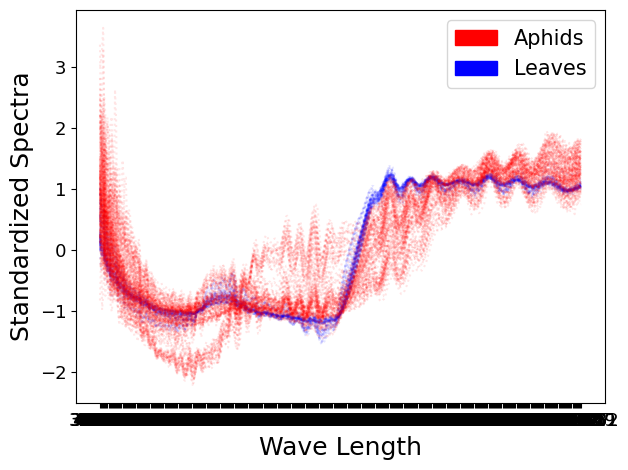

In [38]:
import matplotlib.patches as mpatches

_=plt.plot(X_explore[scores["class"].isin(["leave"]).values].T,"b:",alpha=0.1)

_=plt.plot(X_explore[scores["class"].isin(["aphid",]).values].T,"r:",alpha=0.1)

red_patch = mpatches.Patch(color='red', label='Aphids')
blue_patch = mpatches.Patch(color='blue', label='Leaves')
plt.legend(handles=[red_patch,blue_patch],fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Wave Length",fontsize=18)
plt.ylabel("Standardized Spectra",fontsize=18)
plt.tight_layout()
#plt.savefig("Normalized_spectra.pdf")

### Plot distribution of scores according to each possible class (aphid, leave, other background)

In [40]:
#sns.displot(data=scores,x="score",hue="class")
_=plt.hist(scores[scores["class"]=="aphid"]["score"],bins=20,log=True,alpha=0.8,label="Aphids",color="DarkRed")
_=plt.hist(scores[scores["class"]=="leave"]["score"],bins=20,log=True,alpha=0.8,label="Leaves",color="DarkBlue")
_=plt.hist(scores[scores["class"]=="other"]["score"],bins=200,log=True,alpha=0.8,label="Other",color="LightBlue")
plt.vlines(x=-svm.intercept_,ymin=0,ymax=20**2,linestyle="--")
plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Scores",fontsize=18)
plt.ylabel("Frequency",fontsize=18)
plt.tight_layout()
#plt.savefig("Scores_distribution.pdf")

### PCA based representation

In [41]:
from sklearn.metrics import pairwise_distances_argmin_min
scores["support_vectors"] = False
amin_val, min_val = pairwise_distances_argmin_min(svm.support_vectors_,X_explore)
scores.loc[scores.index[amin_val],"support_vectors"] = True

In [42]:
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
mds = PCA(2)
#mds = TSNE(2,init="pca",learning_rate="auto")
to_choose = Z>0.1
X_explore_tsne = mds.fit_transform(X=X_explore[to_choose])
X_explore_tsne = pd.DataFrame(X_explore_tsne,columns=["TSNE 1", "TSNE 2"])
X_explore_tsne["score"] = scores[to_choose]["score"].values
X_explore_tsne["prediction"] = Z[to_choose]>=svm.offset_
X_explore_tsne["border"] = scores[to_choose]["support_vectors"].values#np.logical_and(Z[to_choose]<svm.offset_,Z[to_choose]>=0.49)#support_vectors
X_explore_tsne["class"] = scores[to_choose]["class"].values

In [43]:
X_explore_tsne.columns = ['TSNE 1', 'TSNE 2', 'Score', 'prediction', 'border', 'Class']
mapper_class_tsne = {'aphid':"Aphid", 'leave':"Leaf", 'other':"Other"}
X_explore_tsne["Class"] = [mapper_class_tsne[m] for m in X_explore_tsne["Class"]]

In [44]:
np.cumsum(mds.explained_variance_ratio_)

array([0.56277947, 0.77479755])

In [45]:
X_explore_tsne_false = X_explore_tsne[np.logical_and(X_explore_tsne["prediction"]==False,X_explore_tsne["border"]==False)]
X_explore_tsne_true = X_explore_tsne[np.logical_and(X_explore_tsne["prediction"]==True,X_explore_tsne["border"]==False)]
X_explore_tsne_border = X_explore_tsne[X_explore_tsne["border"]==True]


sns.scatterplot(data = X_explore_tsne_false,
                x="TSNE 1", y="TSNE 2",
                hue="Score", linewidth=1,alpha=0.9,s=70,
                palette=sns.color_palette("Blues_r", as_cmap=True),
                style="Class",style_order=["Aphid","Leaf","Other"],
                legend=True,edgecolor="b")

sns.scatterplot(data = X_explore_tsne_true,
                x="TSNE 1", y="TSNE 2",hue="Score",s=70,
                linewidth=1,alpha=0.9,palette=sns.color_palette("Reds", as_cmap=True),
                style="Class",style_order=["Aphid","Leaf","Other"],
                legend=True,edgecolor="r")


sns.scatterplot(data = X_explore_tsne_border,
                x="TSNE 1", y="TSNE 2",s=100,
                linewidth=4,alpha=0.3,color="gray",
                style="Class",style_order=["Aphid","Leave","Other"],
                legend=False,edgecolor="DarkGreen")

plt.legend(bbox_to_anchor=(1.0, 1), 
           loc='upper left', borderaxespad=0,
           title="",ncol=1,fontsize=9)
plt.xlabel("$PC$ $0$",fontsize=18)
plt.ylabel("$PC$ $1$",fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("PCA.pdf")

In [46]:
svm.offset_,len(svm.support_vectors_)

(array([0.49497953]), 12)

In [47]:
np.cumsum(mds.explained_variance_ratio_)

array([0.56277947, 0.77479755])

### Scores vs. Stages, background

In [48]:
dataset = pd.read_csv("data_training/20211118_spectrum_avg_norm_zscore.csv",index_col=0)
dataset["score"] = Z
dataset = dataset[dataset["score"]>0.1]
dataset["type"] = [f[0] for f in dataset["file"]]
dataset["stage"] = [f[1:3] for f in dataset["file"]]
dataset["on leave"] = [f[-1]=="F" for f in dataset["file"]]

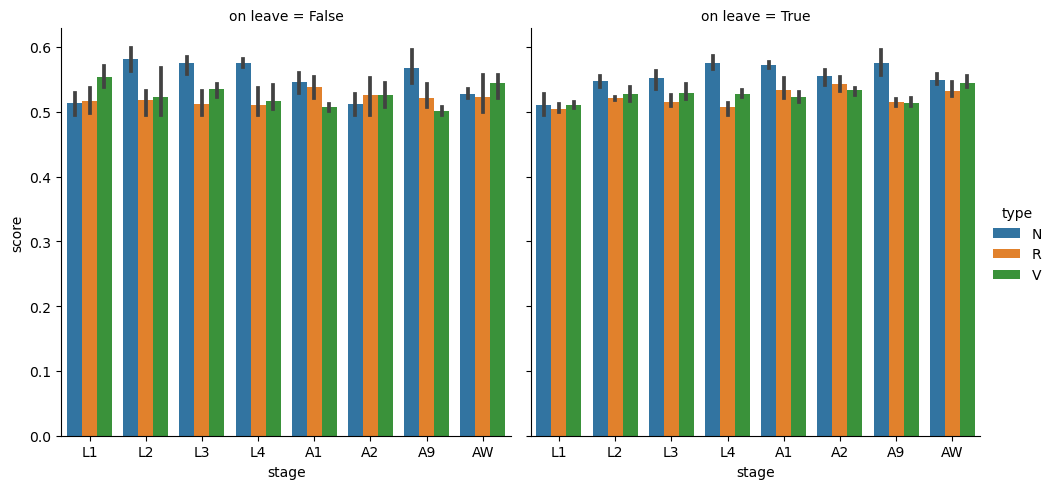

In [51]:
aphids = dataset[dataset["is_aphid"]==True]
sns.catplot(data=aphids,hue="type",x="stage",
            y="score",col="on leave",kind="bar",
           order= ["L1","L2","L3","L4","A1","A2","A9","AW"])

### PCA representation per aphid type

In [52]:
pca = PCA(2)
dataset_top = dataset[dataset["score"]>0.1]
dataset_pca = pca.fit_transform(dataset_top[[str(w) for w in wave_lengths]])

In [53]:
dataset_pca = pd.DataFrame(dataset_pca,index=dataset_top.index)
dataset_pca["type"] = dataset_top["type"]
dataset_pca["stage"] = dataset_top["stage"]
dataset_pca["On Leave"] = dataset_top["on leave"]
dataset_pca["score"] = dataset_top["score"]
dataset_pca["is_aphid"] = dataset_top["is_aphid"]
dataset_pca["is_leave"] = dataset_top["is_leave"]

In [54]:
np.unique(dataset_pca["stage"])
mapper = {"A1":"A1","A2":"A2","A9":"A9","AW":"AW",
          "L1":"N1","L2":"N2","L3":"N3","L4":"N4"}
dataset_pca["stage"] = [mapper[m] for m in dataset_pca["stage"]]

In [55]:
final_class = []
for i in dataset_pca.index:
    if dataset_pca.loc[i,"is_leave"]:
        final_class.append("Leave")
    elif dataset_pca.loc[i,"is_aphid"]:
        final_class.append("Aphid "+dataset_pca.loc[i,"type"])
    else:
        final_class.append("Other")
dataset_pca["Class"] = final_class    
dataset_pca = dataset_pca.sort_values("Class")

In [56]:
mapper_class = {'Aphid N':'$R.$ $padi$ LR01',
                'Aphid R':'$A.$ $pisum$ YR2', 
                'Aphid V':'$A.$ $pisum$ LL01',
                'Leave':'Leaf', 'Other':'Other'}
dataset_pca["Class"] = [mapper_class[m] for m in dataset_pca["Class"]]

In [57]:
dataset_pca.columns = [0, 1, 'type', 'stage', 'On Leaf', 'score', 'is_aphid', 'is_leave','Class']

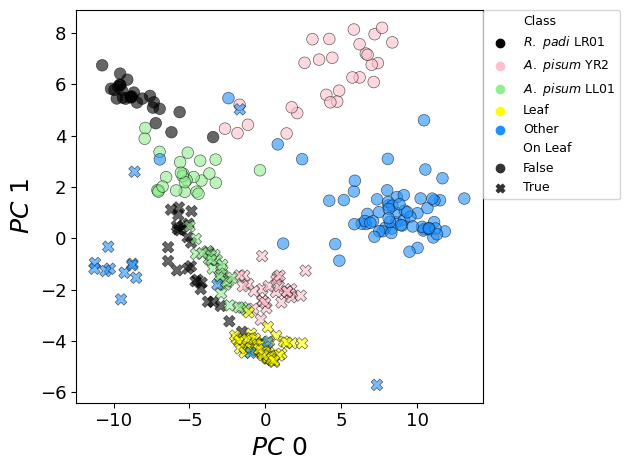

In [58]:

sns.scatterplot(data = dataset_pca,
                x=0, y=1,s=70,
                linewidth=0.5,alpha=0.6,hue="Class",
                style="On Leaf",
                edgecolor="k",
                palette=['black','pink','LightGreen',"yellow",'dodgerblue'])
plt.legend(bbox_to_anchor=(1., 1), 
           loc='upper left', borderaxespad=0,
           title="",ncol=1,fontsize=9)

plt.xlabel("$PC$ 0",fontsize=18)
plt.ylabel("$PC$ 1",fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("PCA-classes.pdf")

### Plot spectra per class

In [59]:
final_class = []
for i in dataset_top.index:
    if dataset_top.loc[i,"is_leave"]:
        final_class.append("Leave")
    elif dataset_top.loc[i,"is_aphid"]:
        final_class.append("Aphid "+dataset_pca.loc[i,"type"])
    else:
        final_class.append("Other")
dataset_top["Class"] = final_class  

In [60]:
colors = {"Aphid N":'black',
          "Aphid R":'lightcoral',
          "Aphid V":'LightGreen',
          "Leave":"yellow",
          "Other":'dodgerblue'}

spectra = []
wave_lengths_ = []
class_ = []
on_leave = []

for i in dataset_top.index:
    s = list(dataset_top.loc[i,wave_lengths.astype(str)].values)
    spectra += s
    wave_lengths_ += list(wave_lengths.values)
    class_ += [dataset_top.loc[i,"Class"] for _ in range(len(s))]
    on_leave += [dataset_top.loc[i,"on leave"] for _ in range(len(s))]
    '''
    plt.plot(wave_lengths.values,
             dataset_top.loc[i,wave_lengths.astype(str)].values,
             linestyle=":",
             marker="*",
             markersize=5,
             markevery=20,
             alpha=0.05,
             color = colors[dataset_top.loc[i,"Class"]]
             )
    '''
linear_dataset = pd.DataFrame({"Spectra":spectra,
              "Wave Length":wave_lengths_,
              "Class":class_,
              "On Leave":on_leave})
              

In [61]:
linear_dataset = linear_dataset.sort_values("Class")

In [62]:
linear_dataset.columns = ['Spectra', 'Wave Length', 'Class', 'On Leaf']

In [63]:
mapper_class = {'Aphid N':'$R.$ $padi$ LR01',
                'Aphid R':'$A.$ $pisum$ YR2', 
                'Aphid V':'$A.$ $pisum$ LL01',
                'Leave':'Leaf', 'Other':'Other'}
linear_dataset["Class"] = [mapper_class[m] for m in linear_dataset["Class"]]


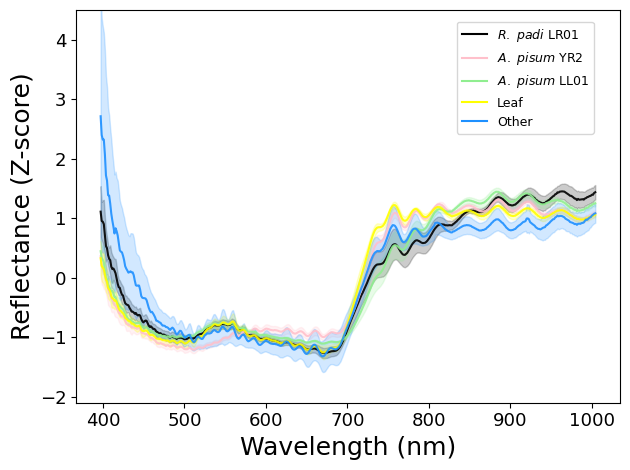

In [67]:
sns.lineplot(data=linear_dataset[linear_dataset["On Leaf"]],
             x = "Wave Length",
             y = "Spectra",
             hue="Class",
             ci="sd",alpha=0.9,
             markers=False, dashes=True,
             palette=['black','pink','LightGreen',"yellow",'dodgerblue']
             )
plt.legend(bbox_to_anchor=(0.7, 0.97), 
           loc='upper left', borderaxespad=0,
           title="",ncol=1,fontsize=9)

plt.xlabel("Wavelength (nm)",fontsize=18)
plt.ylabel("Reflectance (Z-score)",fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([-2.1,4.5])
plt.tight_layout()
#plt.savefig("Normalized_spectra_colors_on_leave.pdf")

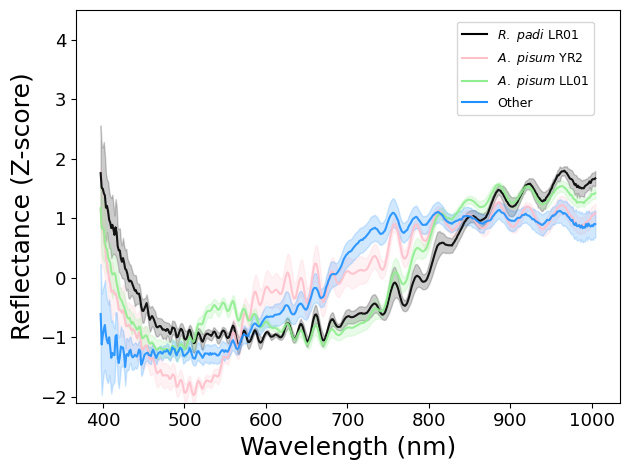

In [68]:

sns.lineplot(data=linear_dataset[np.logical_not(linear_dataset["On Leaf"])],
             x = "Wave Length",
             y = "Spectra",
             hue="Class",
             ci="sd",alpha=0.9,
             markers=False, dashes=True,
             palette=['black','pink','LightGreen','dodgerblue']
             )
plt.legend(bbox_to_anchor=(0.7, 0.97), 
           loc='upper left', borderaxespad=0,
           title="",ncol=1,fontsize=9)


plt.xlabel("Wavelength (nm)",fontsize=18)
plt.ylabel("Reflectance (Z-score)",fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([-2.1,4.5])
plt.tight_layout()
#plt.savefig("Normalized_spectra_colors_no_leave.pdf")

# Feature Importance

In [70]:
from sklearn.inspection import permutation_importance


In [71]:
from sklearn.metrics import f1_score

def one_class_f1_scorer(clf, X, y):
    y_pred = clf.predict(X)>0
    f1 = f1_score(y,y_pred)
    return f1

In [76]:
PI = permutation_importance(svm,
                       X[(y_aphid*2 + y_leave) > 0],
                       y[(y_aphid*2 + y_leave) > 0],
                       scoring=one_class_f1_scorer,
                       n_repeats=100)

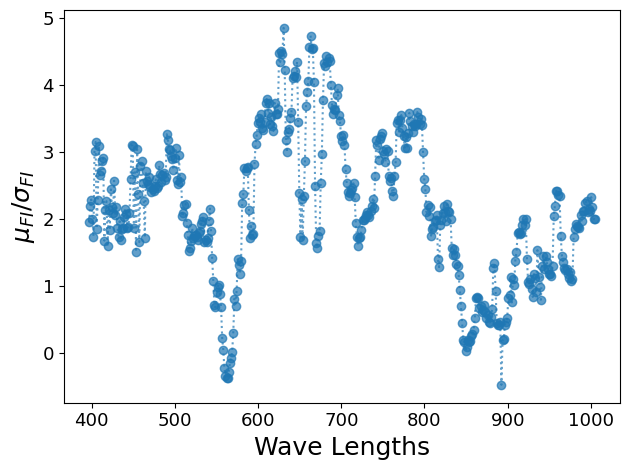

In [77]:
plt.plot(wave_lengths,PI["importances_mean"]/PI["importances_std"],
         "o:",alpha=0.7)
plt.ylabel("$\mu_{FI}/\sigma_{FI} \quad $", fontsize=18)
plt.xlabel("Wave Lengths", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("PI_aphids_leaves.pdf")

In [78]:
PI_rest = permutation_importance(svm,
                       X,
                       y,
                       scoring=one_class_f1_scorer,
                       n_repeats=100)

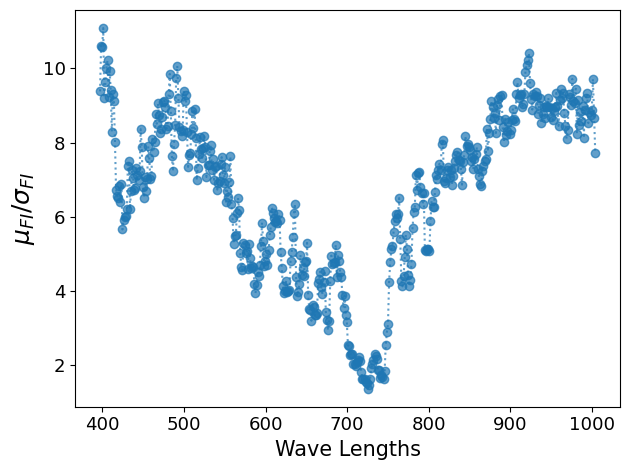

In [80]:
plt.plot(wave_lengths,PI_rest["importances_mean"]/PI_rest["importances_std"],
         "o:",alpha=0.7)
plt.ylabel("$\mu_{FI}/\sigma_{FI} \quad $", fontsize=18)
plt.xlabel("Wave Lengths", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("PI.pdf")